### Train coronal holes segmentation model

This Notebook explains how to load and preprocess AIA images and corresponding segmentation masks and train a neural network for coronal holes segmentation. 

Start with general imports.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm

sys.path.append("..")

%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_VISIBLE_DEVICES=0


Next step is to provide pathes to source images and target ```.abp``` files and match corresponding pairs.
```FileIndexer``` will do this job. Suppose we want to exploit all images given in ```.blosc``` format from
directory ```C:/AIA/``` and all ```.abp``` files from the same directory. Then we set path for images as
```C:/AIA/*.blosc``` and for masks as ```C:/AIA/*.abp```.

How to connect each image with corresponding ```.abp``` file? If filenames (without extensions) are 
the same for image and corresponding ```.abp``` file, then they will be matched automatically and no
```make_indices``` function is required.
Otherwise one should define a function that will translate image and ```.abp``` filenames to the same value. For example,
suppose we want to match files ```20080502_1345_aia.blocs``` and ```t20080502.abp```. Both filenames have common substring  ```20080502```,
thus we define ```make_indices``` function for images as ```lambda x: x[:8]``` 
and ```lambda x: x[1:9]```
for ```.abp``` file.

If ```FileIndexer``` fails to match files, e.g. some ```.abp``` files are missed, it raises an error.

In [2]:
from src import FileIndexer

index = FileIndexer([{'name': 'images',
                      'path': 'C:/AIA/*.blosc', #Set correct path to source images
                      'make_indices': lambda name: name[:8]}, #Indicate how to get index from filename
                     {'name': 'masks',
                      'path': 'C:/AIA/*.abp', #Set correct path to abp files
                      'make_indices': lambda name: name[:8]}]) #Indicate how to get index from filename

Then we create an instance of ```BatchGenerator``` that will produce batches for neural network training. We also split dataset into train and test parts and shuffle items in the train part.

In [3]:
from src import ImageBatch, BatchGenerator

bg = BatchGenerator(index, ImageBatch)
bg.train_test_split(train_ratio=0.823, shuffle=False) #Split the dataset into train and test part.
bg.train.shuffle(seed=1234) #Shuffle train items

Check that test indices start at 2017-01-01.

In [4]:
bg.test.indices[0]

'20170101'

Check the preprocess pipeline. Here we declare actions that load and augment images and make segmentation masks.

In [5]:
def preprocess(batch):
    return (batch.load_images(fmt='blosc') #Load source images from blosc file format
            .load_objects() #load coronal holes
            .drop_empty_days() #Drop days without coronal holes
            .make_segmentation_masks((1024, 1024), ohe=False) #Make binary target images
            .downsize_image(['images', 'masks'], 256) #Resize images to 256 x 256
            .random_rot90(['images', 'masks']) #Augmentation
            .random_flip(['images', 'masks'], axis=0) #Augmentation
            .random_flip(['images', 'masks'], axis=1) #Augmentation
            .apply(lambda x: x / 255, ['images']) #Change pixel intensity range to [0, 1]
           )

Build a tensorflow graph and create a session for model training.

In [6]:
from src import u_net, conv_block

image_shape = (256, 256, 1)
mask_shape = (256, 256, 1)

unet_depth = 4 #Depth of u-net network
unet_init_filters = 24 #Number of filters int the first conv layer

learning_rate = 0.001

config = tf.ConfigProto()
graph = tf.Graph()
with graph.as_default():
    images = tf.placeholder('float', shape=(None, ) + image_shape, name='images')
    masks = tf.placeholder('float', shape=(None, ) + mask_shape, name='masks')
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    res = u_net(images, unet_depth, unet_init_filters, is_training=is_training)
    logits = conv_block(res, 'c', mask_shape[-1])    
    predict = tf.nn.sigmoid(logits)
    print('output', predict.get_shape())

    loss = tf.losses.log_loss(tf.cast(masks, 'float'), predict)

    optimizer = tf.train.AdamOptimizer(learning_rate)
    unet_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        step = optimizer.minimize(loss, var_list=unet_vars)
    
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

input (?, 256, 256, 1)
conv_block_0 (?, 256, 256, 24)
pool_0 (?, 128, 128, 24)
conv_block_1 (?, 128, 128, 48)
pool_1 (?, 64, 64, 48)
conv_block_2 (?, 64, 64, 96)
pool_2 (?, 32, 32, 96)
conv_block_3 (?, 32, 32, 192)
pool_3 (?, 16, 16, 192)
bottom_conv_block_4 (?, 16, 16, 384)
up_3 (?, 32, 32, 384)
concat_4 (?, 32, 32, 576)
up_conv_block_4 (?, 32, 32, 192)
up_2 (?, 64, 64, 192)
concat_3 (?, 64, 64, 288)
up_conv_block_3 (?, 64, 64, 96)
up_1 (?, 128, 128, 96)
concat_2 (?, 128, 128, 144)
up_conv_block_2 (?, 128, 128, 48)
up_0 (?, 256, 256, 48)
concat_1 (?, 256, 256, 72)
up_conv_block_1 (?, 256, 256, 24)
output (?, 256, 256, 1)


Now we can set ```n_epochs``` and ```batch_size``` and run training. ```loss_history``` will accumulate loss at each iteration.

In [7]:
n_epochs = 3
batch_size = 20
n_iter = len(bg.train) // batch_size

loss_history = []

for ep in range(n_epochs):
    loss_on_epoch = []
    t = tqdm.tqdm(range(n_iter), desc="Epoch {0} / {1}".format(ep + 1, n_epochs), leave=True)
    for i in t:
        next_batch = bg.train.next_batch(batch_size, n_epochs=None, shuffle=True, drop_last=True)   
        train_batch = preprocess(next_batch)
        x = np.array([i for i in train_batch.images])
        y = np.array([i for i in train_batch.masks])
        res = sess.run([loss, step], feed_dict={images: x, masks: y, is_training: True})
        loss_on_epoch.append(res[0])
        t.set_postfix(loss=res[0], avr_loss=np.mean(loss_on_epoch))
    loss_history.extend(loss_on_epoch)
loss_history = np.array(loss_history)

Epoch 3 / 3: 100%|█████████████████████████████████████| 119/119 [03:54<00:00,  1.97s/it, avr_loss=0.0182, loss=0.0105]


Plot loss against iterations.

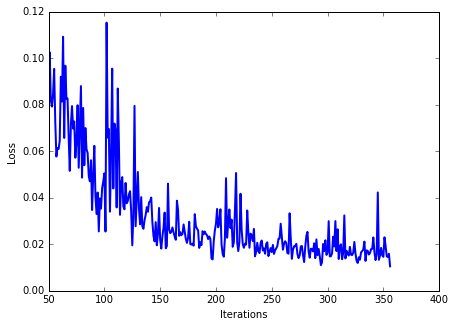

In [8]:
%matplotlib inline

plt.figure(figsize=(7, 5))
skip_iters = 50
plt.plot(np.arange(skip_iters, len(loss_history)), loss_history[skip_iters:], linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

Evaluate the model on the test part of the dataset. Note the ```test_preprocess``` does not include augmentations anymore.

In [9]:
predicts = [] #Predicted masks
targets = [] #Target masks
inputs = [] #Source images

def test_preprocess(batch):
    return (batch.load_images(fmt='blosc')
            .load_objects()
            .make_segmentation_masks((1024, 1024), ohe=False)
            .downsize_image(['images', 'masks'], 256)
            .apply(lambda x: x / 255, ['images'])
           )

batch_size = 20
bg.test.reset()
for _ in range(len(bg.test) // batch_size):
    next_batch = bg.test.next_batch(batch_size, n_epochs=1, shuffle=False, drop_last=False)   
    test_batch = test_preprocess(next_batch)
    x_test = np.array([i for i in test_batch.images])
    y_test = np.array([i for i in test_batch.masks])
    out = sess.run(predict, feed_dict={images: x_test, is_training: False})
    
    predicts.extend(out)
    targets.extend(y_test)
    inputs.extend(x_test)

Plot sample image from the test subset with corresponding predicted (in green color) and target (in red color) segmentation map.


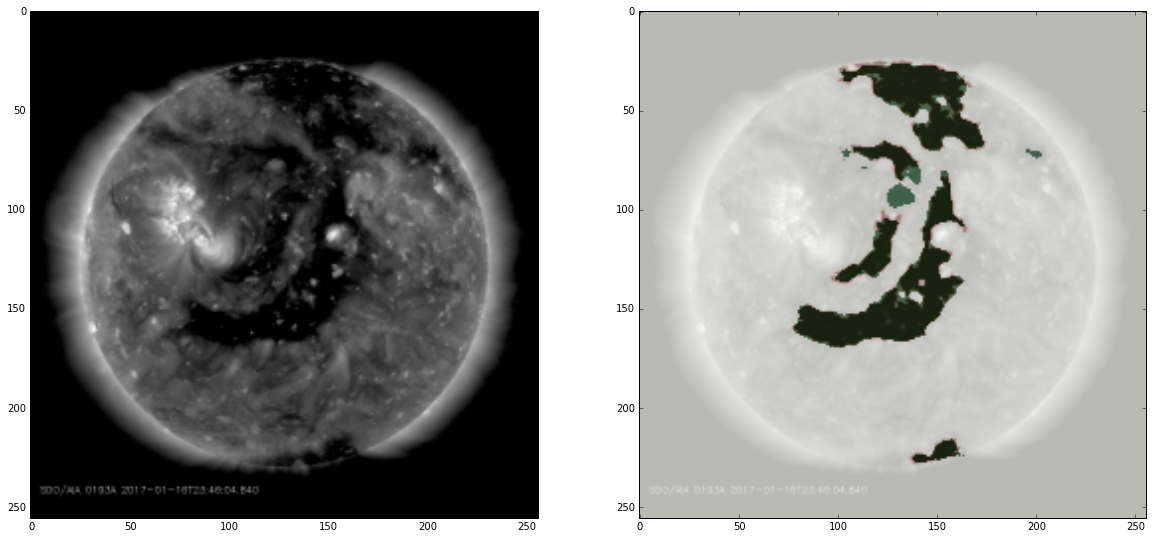

In [10]:
i = 15

%matplotlib inline
fsize = 20
fig, axes = plt.subplots(1, 2, figsize=(fsize, fsize))
axes[0].imshow(inputs[i][:, :, 0], cmap='gray', alpha=1)
axes[1].imshow(inputs[i][:, :, 0], cmap='gray', alpha=1)
axes[1].imshow(targets[i][:,:, 0], cmap='Reds', alpha=0.5)
axes[1].imshow(np.rint(predicts[i][:, :, 0]), cmap='Greens', alpha=0.5)
plt.show()

Save trained model.

In [11]:
saver.save(sess, "../model_dumps/ch_seg_model.ckpt") #Set correct path where to save the model

'../model_dumps/ch_seg_model.ckpt'

Done! See the next [Notebook](https://github.com/observethesun/coronal_holes/blob/master/run_segmentation_model.ipynb/) on how to use the saved model.